# LDA TOPIC MODELING 

This notebook applies LDA modeling to a dataset from a Kaggle dataset of news headlines:

https://www.kaggle.com/therohk/million-headlines

using GENSIM toolkit:

https://radimrehurek.com/gensim/

and following a really useful tutorial from machinelearningplus website:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/



__Steps__

- Text porcessing
- Bulding the model

__Other interesting links:__

- https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

- https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

- https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d

- https://stackoverflow.com/questions/20984841/topic-distribution-how-do-we-see-which-document-belong-to-which-topic-after-doi

- https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

__Required Libraries__

In [1]:
import pandas as pd
import numpy as np


import string
import re
from pprint import pprint

# NLTK 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') #this depends on each language

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

__Loading data__

In [2]:
df=pd.read_csv('./abcnews-date-text.csv',sep=',')

In [3]:
df.shape[0]

1103665

In [4]:
df.head(1)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...


In [5]:
data=df['headline_text'].values.tolist()

In [6]:
pprint(data[:1])

['aba decides against community broadcasting licence']


__Tokenize words and Clean-up text__

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']]


__Bigrams & Trigrams__

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/home/anotario/anaconda2/envs/EI_python36/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']


__Remove Stopwords, Make Bigrams and Lemmatize__

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

__Let’s call the functions in order__

In [10]:
#To run this code it is necessary to get the spacy moidel: "!python - m spacy download en", last depends on the used language 

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'es' model, keeping only tagger component (for efficiency)
# python3 -m spacy download es
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['aba', 'decide', 'community', 'broadcasting', 'licence']]


__Create the Dictionary and Corpus needed for Topic Modeling__

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


If you want to see what word a given id corresponds to, pass the id as a key to the dictionary

In [12]:
id2word[0]

'aba'

Or, you can see a human-readable form of the corpus itself.

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('aba', 1),
  ('broadcasting', 1),
  ('community', 1),
  ('decide', 1),
  ('licence', 1)],
 [('act', 1),
  ('aware', 1),
  ('defamation', 1),
  ('fire', 1),
  ('must', 1),
  ('witness', 1)]]

__Building the Topic Model__

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=4,
                                           alpha='auto',
                                           per_word_topics=True)

__View the topics in LDA model__

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"ash" + 0.048*"die" + 0.031*"work" + 0.031*"north_korea" + '
  '0.028*"rise" + 0.020*"announce" + 0.020*"break" + 0.016*"food" + '
  '0.015*"continue" + 0.014*"threat"'),
 (1,
  '0.059*"child" + 0.035*"use" + 0.028*"young" + 0.022*"story" + 0.022*"hold" '
  '+ 0.018*"fear" + 0.018*"cricket" + 0.016*"debate" + 0.015*"pm" + '
  '0.014*"crisis"'),
 (2,
  '0.059*"woman" + 0.057*"queensland" + 0.055*"election" + '
  '0.039*"sex_marriage" + 0.033*"adelaide" + 0.029*"people" + 0.019*"road" + '
  '0.019*"force" + 0.017*"community" + 0.015*"push"'),
 (3,
  '0.050*"test" + 0.034*"south" + 0.033*"labor" + 0.030*"house" + 0.027*"go" + '
  '0.026*"tell" + 0.025*"claim" + 0.024*"city" + 0.023*"pay" + 0.019*"week"'),
 (4,
  '0.049*"find" + 0.047*"death" + 0.045*"fire" + 0.036*"perth" + '
  '0.030*"former" + 0.027*"miss" + 0.019*"search" + 0.016*"baby" + '
  '0.015*"history" + 0.014*"mother"'),
 (5,
  '0.050*"take" + 0.036*"open" + 0.031*"north" + 0.026*"victoria" + '
  '0.026*"west" + 0

__Compute Model Perplexity and Coherence Score__

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.043624796173853

Coherence Score:  0.2335542863866586


__Visualize the topics-keywords__

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/anotario/anaconda2/envs/EI_python36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.412307  0.020040       1        1  15.573314
7     -0.128775  0.029068       2        1   5.927447
16    -0.027554 -0.110940       3        1   5.256465
14    -0.008084 -0.089262       4        1   5.120751
4      0.015089  0.160504       5        1   5.070335
2      0.036795  0.359188       6        1   4.898608
15     0.028787 -0.052957       7        1   4.643986
19     0.019333  0.016390       8        1   4.597430
18    -0.039104 -0.065854       9        1   4.570620
10     0.044645 -0.031696      10        1   4.410382
3      0.016386 -0.005550      11        1   4.337200
6      0.039215 -0.076503      12        1   4.335672
5      0.041104 -0.062989      13        1   4.251004
9      0.078741 -0.019495      14        1   4.211429
0      0.030832 -0.031079      15        1   4.043561
11     0.014206 -0.065209      16        1   4.005229
12     0.065024 -0.016892      17        1   3.868320
17     0.067054 -0.021218      18        1   3.771629
8      0.069751  0.053047      19        1   3.568681
1      0.048860  0.011407      20        1   3.537927, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
44    Default  28414.000000   australia  28414.000000  30.0000  30.0000
298   Default  28683.000000         man  28683.000000  29.0000  29.0000
259   Default  25387.000000      police  25387.000000  28.0000  28.0000
23    Default  22229.000000  australian  22229.000000  27.0000  27.0000
439   Default  36417.000000         say  36417.000000  26.0000  26.0000
413   Default  30071.000000         new  30071.000000  25.0000  25.0000
2558  Default  16727.000000      sydney  16727.000000  24.0000  24.0000
1250  Default  16828.000000        year  16828.000000  23.0000  23.0000
233   Default  15256.000000       court  15256.000000  22.0000  22.0000
11    Default  15652.000000        call  15652.000000  21.0000  21.0000
2895  Default  14637.000000  government  14637.000000  20.0000  20.0000
391   Default  15203.000000       woman  15203.000000  19.0000  19.0000
348   Default  15197.000000      charge  15197.000000  18.0000  18.0000
2369  Default  14802.000000  queensland  14802.000000  17.0000  17.0000
9985  Default  13969.000000       trump  13969.000000  16.0000  16.0000
1073  Default  14277.000000    election  14277.000000  15.0000  15.0000
188   Default  13908.000000         nsw  13908.000000  14.0000  14.0000
29    Default  12289.000000         win  12289.000000  13.0000  13.0000
296   Default  13142.000000        find  13142.000000  12.0000  12.0000
157   Default  12631.000000       death  12631.000000  11.0000  11.0000
959   Default  13046.000000   melbourne  13046.000000  10.0000  10.0000
920   Default  10920.000000       child  10920.000000   9.0000   9.0000
1843  Default  11527.000000        test  11527.000000   8.0000   8.0000
8     Default  12022.000000        fire  12022.000000   7.0000   7.0000
2476  Default  11166.000000         ash  11166.000000   6.0000   6.0000
55    Default  11263.000000        take  11263.000000   5.0000   5.0000
326   Default  11189.000000      murder  11189.000000   4.0000   4.0000
831   Default  10194.000000       could  10194.000000   3.0000   3.0000
93    Default  10766.000000      attack  10766.000000   2.0000   2.0000
191   Default  10126.000000         die  10126.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
920   Topic20  10920.034180       child  10920.833984   3.3416  -2.8365
975   Topic20   6548.459473         use   6549.258789   3.3415  -3.3479
387   Topic20   5220.338867       young   5221.138184   3.3415  -3.5745
5266  Topic20   4147.735352       story   4148.534668   3.3414  -3.8045
163   Topic20   4084.523193        hold   4085.322510   3.3414  -3.8199
806   Topic20   3427.890137      

__Building LDA Mallet Model__

The MALLET topic model package includes an extremely fast and highly scalable implementation of Gibbs sampling, efficient methods for document-topic hyperparameter optimization, and tools for inferring topics for new documents given trained models. 

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('rise', 0.0337363869314542),
   ('power', 0.028547405509288918),
   ('job', 0.027486386931454197),
   ('price', 0.02595691864189622),
   ('mine', 0.024347373478539398),
   ('rate', 0.021168321588725177),
   ('cut', 0.019238468930172965),
   ('fear', 0.016800128122998078),
   ('mining', 0.016335682254964765),
   ('cost', 0.015939301729660474)]),
 (19,
  [('govt', 0.06652636042735814),
   ('urge', 0.0510324680678967),
   ('boost', 0.03185946340716426),
   ('service', 0.03117232930607309),
   ('government', 0.030618695544622487),
   ('fund', 0.029833399429089726),
   ('nt', 0.024721121716971425),
   ('act', 0.02423031164476345),
   ('indigenous', 0.024037914096457922),
   ('budget', 0.021897982181631137)]),
 (3,
  [('plan', 0.08121989345072894),
   ('council', 0.06595128720451718),
   ('water', 0.04817845407854021),
   ('change', 0.035685233036654225),
   ('back', 0.03469231505407216),
   ('ban', 0.03275433055794813),
   ('law', 0.025508820620793057),
   ('push', 0.0245079273933

__How to find the optimal number of topics for LDA?__

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

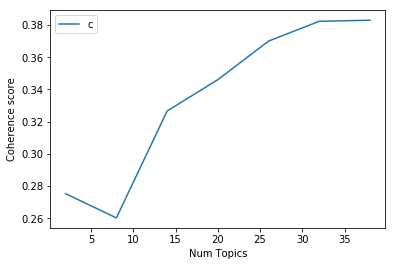

In [22]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2752
Num Topics = 8  has Coherence Value of 0.2602
Num Topics = 14  has Coherence Value of 0.3266
Num Topics = 20  has Coherence Value of 0.3461
Num Topics = 26  has Coherence Value of 0.3701
Num Topics = 32  has Coherence Value of 0.3824
Num Topics = 38  has Coherence Value of 0.383


In [24]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.032*"farmer" + 0.026*"price" + 0.023*"china" + 0.023*"deal" + '
  '0.022*"industry" + 0.015*"company" + 0.014*"farm" + 0.013*"demand" + '
  '0.012*"sale" + 0.012*"gas"'),
 (1,
  '0.038*"hospital" + 0.034*"boost" + 0.034*"health" + 0.032*"service" + '
  '0.030*"fund" + 0.028*"govt" + 0.025*"urge" + 0.025*"indigenous" + '
  '0.023*"government" + 0.022*"budget"'),
 (2,
  '0.051*"plan" + 0.040*"govt" + 0.029*"power" + 0.025*"nt" + 0.025*"mine" + '
  '0.020*"vic" + 0.017*"tas" + 0.017*"decision" + 0.016*"station" + '
  '0.015*"rail"'),
 (3,
  '0.117*"man" + 0.069*"charge" + 0.061*"court" + 0.049*"face" + '
  '0.037*"murder" + 0.034*"jail" + 0.034*"accuse" + 0.028*"drug" + '
  '0.027*"woman" + 0.027*"arrest"'),
 (4,
  '0.067*"fire" + 0.030*"warn" + 0.026*"home" + 0.023*"fear" + 0.023*"house" + '
  '0.017*"spark" + 0.017*"bushfire" + 0.016*"threat" + 0.016*"blaze" + '
  '0.016*"school"'),
 (5,
  '0.043*"qld" + 0.040*"nsw" + 0.028*"south" + 0.028*"hit" + 0.027*"flood" + '
  '0.021*"q

__Finding the dominant topic in each sentence__

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.0778,"plan, govt, power, nt, mine, vic, tas, decisio...",aba decides against community broadcasting lic...
1,1,4.0,0.0737,"fire, warn, home, fear, house, spark, bushfire...",act fire witnesses must be aware of defamation
2,2,1.0,0.0730,"hospital, boost, health, service, fund, govt, ...",a g calls for infrastructure protection summit
3,3,11.0,0.1101,"rise, worker, job, union, pay, cut, rate, offe...",air nz staff in aust strike for pay rise
4,4,4.0,0.0804,"fire, warn, home, fear, house, spark, bushfire...",air nz strike to affect australian travellers
5,5,4.0,0.0697,"fire, warn, home, fear, house, spark, bushfire...",ambitious olsson wins triple jump
6,6,13.0,0.0998,"win, world, australia, test, cup, aussie, lead...",antic delighted with record breaking barca
7,7,12.0,0.0982,"open, final, return, lose, afl, clash, tiger, ...",aussie qualifier stosur wastes four memphis match
8,8,6.0,0.0778,"kill, attack, iraq, war, blast, pakistan, visi...",aust addresses un security council over iraq
9,9,2.0,0.0636,"plan, govt, power, nt, mine, vic, tas, decisio...",australia is locked into war timetable opp


In [26]:
df_dominant_topic.shape

(1103665, 5)

__Find the most representative document for each topic__

In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1791,"farmer, price, china, deal, industry, company,...",glyphosate herbicide crops grain weeds livesto...
1,1.0,0.1518,"hospital, boost, health, service, fund, govt, ...",hospitals to receive extra emergency ward funding
2,2.0,0.1647,"plan, govt, power, nt, mine, vic, tas, decisio...",springsure creek coal mine plan gets environme...
3,3.0,0.1667,"man, charge, court, face, murder, jail, accuse...",jury acquits man accused of ivy nightclub rape
4,4.0,0.1647,"fire, warn, home, fear, house, spark, bushfire...",fire retardant foam engulfs californian airpor...


__Topic distribution across documents__

In [29]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,2.0,"plan, govt, power, nt, mine, vic, tas, decisio...",80643.0,0.0731
1,4.0,"fire, warn, home, fear, house, spark, bushfire...",71120.0,0.0644
2,1.0,"hospital, boost, health, service, fund, govt, ...",62728.0,0.0568
3,11.0,"rise, worker, job, union, pay, cut, rate, offe...",78086.0,0.0708
4,4.0,"fire, warn, home, fear, house, spark, bushfire...",55763.0,0.0505
